## 03 Splitting datasets one feature at a time: decision trees

- Pros: Computationally cheap to use,
    easy for humans to understand learned results,
    missing values OK, can deal with irrelevant features
- Cons: Prone to overfitting
- Works with: Numeric values, nominal values

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

### Implement DecisionTreeClassifier

In [2]:
# Check if every item in the dataset is in the same class:
#     If so return the class label
#     Else
#         find the best feature to split the data
#         split the dataset
#         create a branch node
#         for each split
#             call createBranch and add the result to the branch node
#     return branch node

In [3]:
# Function to calculate the Shannon entropy of a dataset
def calcShannonEnt(dataSet):
    from math import log
    numEntries = len(dataSet)
    labelCounts = {}
    # Create dictionary of all possible classes
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = labelCounts[key] / numEntries
        # Logarithm base 2
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [4]:
# Dataset splitting on a given feature
def splitDataSet(dataSet, axis, value):
    # Create separate list
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            # Cut out the feature split on
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis + 1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [5]:
# Choosing the best feature to split on
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain, bestFeature = 0, -1
    for i in range(numFeatures):
        # Create unique list of class labels
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        # Calculate entropy for each split
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / len(dataSet)
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        # Find the best information gain
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [6]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=lambda x: x[1],
                              reverse=True)
    return sortedClassCount[0][0]

In [7]:
# Tree-building code
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    # Stop when all classes are equal
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # When no more features, return majority
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    # Get list of unique values
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(
            splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [8]:
# Plotting tree nodes with text annotations
# Define box and arrow formatting
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")


# Draws annotations with arrows
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    plotTree.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
                          xytext=centerPt, textcoords='axes fraction',
                          va="center", ha="center", bbox=nodeType,
                          arrowprops=arrow_args)

In [9]:
# Identifying the number of leaves in a tree and the depth
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # Test if node is dictionary
        if isinstance(secondDict[key], dict):
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [10]:
# The plotTree function
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    plotTree.ax1.text(xMid, yMid, txtString, va="center", ha="center",
                      rotation=30)


def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1 + numLeafs) / (2 * plotTree.totalW),
              plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1 / plotTree.totalD
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt,
                     leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1 / plotTree.totalD


def createPlot(inTree, figsize):
    fig = plt.figure(1, facecolor='white', figsize=figsize)
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    plotTree.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = getNumLeafs(inTree)
    plotTree.totalD = getTreeDepth(inTree)
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

In [11]:
# Classification function for an existing decision tree
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    # Translate label string to index
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:
        classLabel = valueOfFeat
    return classLabel

In [12]:
# Methods for persisting the decision tree with pickle
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, "wb")
    pickle.dump(inputTree, fw)
    fw.close()


def grabTree(filename):
    import pickle
    fr = open(filename, "rb")
    return pickle.load(fr)

### Experiment 1: Toy dataset

In [13]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [14]:
myDat, labels = createDataSet()

In [15]:
myTree = createTree(myDat, labels)

In [16]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

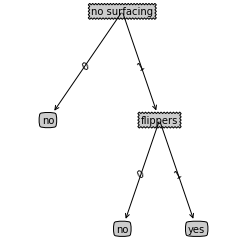

In [17]:
createPlot(myTree, (4, 4))

In [18]:
myDat, labels = createDataSet()

In [19]:
classify(myTree, labels, [1, 0])

'no'

In [20]:
classify(myTree, labels, [1, 1])

'yes'

In [21]:
storeTree(myTree, 'classifierStorage.pkl')

In [22]:
grabTree('classifierStorage.pkl')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### Experiment 2: Lenses dataset

In [23]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)

In [24]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

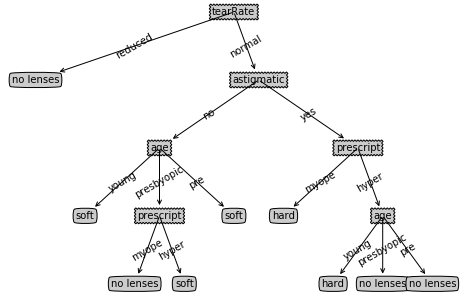

In [25]:
createPlot(lensesTree, (8, 5))